#### Example 4.1

In [1]:
from itertools import product

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import gridworld

seed = 42
terminal_states = ((0, 0), (3, 3))
env = gym.make("GridWorld-v1", shape=(4, 4), terminal_states=terminal_states)
policy = 0.25 * np.ones(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32)
action_str = ["right", "up", "left", "down"]
state, _ = env.reset(seed=seed)
np.random.seed(seed)
print("Initial state:", state)
env.render()

Initial state: [3 1]
T . . . 
. . . . 
. . . . 
. x . T 


In [2]:
action = np.random.choice(env.action_space.n, p=policy[tuple(state)].flatten())
state, reward, terminated, _, info = env.step(action)
print("Action:", action_str[action])
print("Reward:", reward)
print("Terminated:", terminated)
print("State:", state)
env.render()

Action: up
Reward: -1.0
Terminated: False
State: [2 1]
T . . . 
. . . . 
. x . . 
. . . T 


Analytical Solution

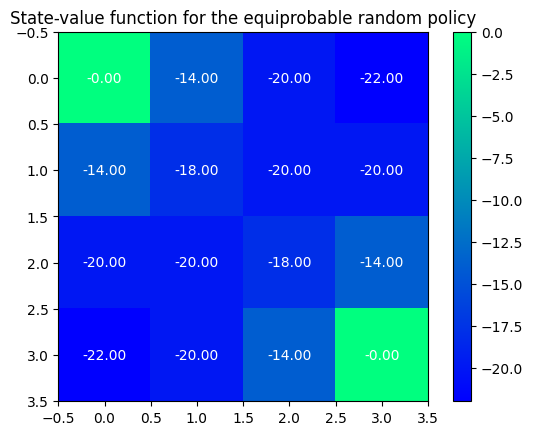

In [3]:
gamma = 1.0
nvec = env.observation_space.nvec
num_states = nvec.prod()
terminal = env.unwrapped.terminal_states
terminal = [terminal[i][0] * nvec[1] + terminal[i][1] for i in range(len(terminal))]
terminal = np.diag([1 if i in terminal else 0 for i in range(num_states)])
transition_prob = env.unwrapped.prob.transpose(0, 1, 3, 4, 2)
rewards = env.unwrapped.rewards.transpose(0, 1, 3, 4, 2)
pol = np.expand_dims(policy, (2, 4))
C = (transition_prob @ pol).reshape(num_states, num_states)
A = (np.eye(num_states) - terminal) - gamma * C
b = ((transition_prob * rewards).sum(axis=(2, 3), keepdims=True) @ pol).reshape(num_states)
v = np.linalg.solve(A, b).reshape(nvec)

plt.imshow(v, cmap="winter")
for state in product(*[range(i) for i in v.shape]):
    plt.text(*state[::-1], f"{v[state]:.2f}", ha="center", va="center", color="white")
plt.title("State-value function for the equiprobable random policy")
plt.colorbar()
plt.show()

#### Figure 4.1

Interative Policy Evaluation, for estimating $V \approx v_\pi$

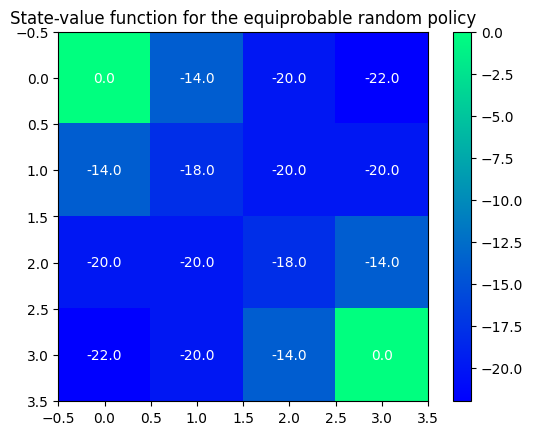

In [4]:
theta = 0.001
V = np.zeros(num_states)
while True:
    v = V.copy()
    V = b + gamma * C @ V
    delta = max(abs(V - v))
    if delta < theta:
        break

V = V.reshape(nvec)
plt.imshow(V, cmap="winter")
for state in product(*[range(i) for i in V.shape]):
    plt.text(*state[::-1], f"{V[state]:.1f}", ha="center", va="center", color="white")
plt.title("State-value function for the equiprobable random policy")
plt.colorbar()
plt.show()

#### Exercise 4.1
In Example 4.1, if $\pi$ is the equiprobable random policy, what is $q_\pi(11, \text{down})$? What is $q_\pi(7, \text{down})$

- $q_\pi(11, \text{down}) = -1 + 1 * v_\pi(T) = -1$
- $q_\pi(7, \text{down}) = -1 + 1 * v_\pi(11) = -15$

#### Exercise 4.2
In Example 4.1, suppose a new state 15 is added to the gridworld just below state 13, and its actions, left, up, right, and down, take the agent to states 12, 13, 14, and 15, respectively. Assume that the transitions from the original states are unchanged. What, then, is $v_\pi(15)$ for the equiprobable random policy? Now suppose the dynamics of state 13 are also changed, such that action down from state 13 takes the agent to the new state 15. What is $v_\pi(15)$ for the equiprobable random policy in this case?

- $v_\pi (15) = -1 + 0.25 \gamma [v_\pi(12) + v_\pi(13) + v_\pi(14) + v_\pi(15)] = -15 + 0.25 v_\pi(15) = -20$

Allowing down transition

- $\left\{\begin{array}{ll}
    v_\pi (13) = -1 + 0.25 \gamma [-56 + v_\pi(15)] \\
    v_\pi (15) = -1 + 0.25 \gamma [-36 + v_\pi(13) + v_\pi(15)]
    \end{array} \right.$
- $v_\pi (13) = - 20$
- $v_\pi (15) = - 20$

#### Exercise 4.3
What are the equations analogous to (4.3), (4.4), and (4.5), but for action-value functions instead of state-value functions?
- $q_\pi(s, a) = \mathbb{E}_\pi[R_{t+1} + \gamma q_\pi(S_{t+1}, A_{t+1}) | S_t = s, A_t = a]$
- $q_\pi(s, a) = \sum_{s', r} p(s', r| s, a)[r + \gamma \sum_{a'} \pi(a' | s') * q_\pi(s', a')]$
- $q_{k+1}(s, a) = \sum_{s', r} p(s', r| s, a)[r + \gamma \sum_{a'} \pi(a' | s') * q_k(s', a')]$

#### Example 4.2: Jack's Car Rental

In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import car_rental

seed = 42
env = gym.make("CarRental-v0")
policy = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32)
policy[:, :, 0] = 1.0

def plot_value(value, title=None):
    plt.imshow(np.flip(value, axis=0), cmap="plasma")
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()

def get_deterministic(policy):
    deterministic = np.flip(np.argmax(policy, axis=2), axis=0)
    deterministic -= env.action_space.n * (deterministic // (-env.action_space.start + 1))
    return deterministic
    
def plot_policy(policy, title=None):
    deterministic = get_deterministic(policy)
    plt.imshow(deterministic, cmap="plasma", vmin=env.action_space.start, vmax=-env.action_space.start)
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()

In [6]:
state, _ = env.reset(seed=seed)
np.random.seed(seed)
print("Initial state:", state)

Initial state: [16  9]


In [7]:
action = np.random.choice(env.action_space.n, p=policy[tuple(state)].flatten())
action -= env.action_space.n * (action // (-env.action_space.start + 1))
state, reward, _, _, info = env.step(action)
print("Action:", action)
print("Reward:", reward)
print("Rentals:", info["rentals"])
print("Returns:", info["returns"])
print("State:", state)

Action: 0
Reward: 90.0
Rentals: [4 5]
Returns: [4 1]
State: [16  5]


#### Figure 4.2

Policy Iteration (using iterative policy evaluation) for estimating $\pi \approx \pi_*$

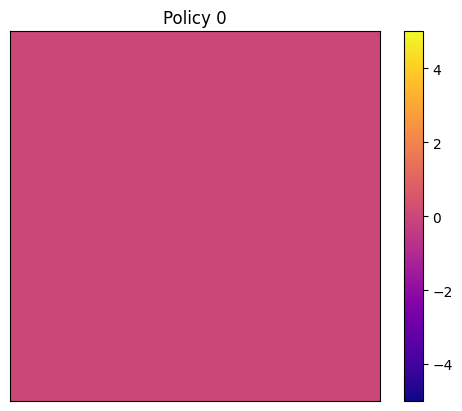

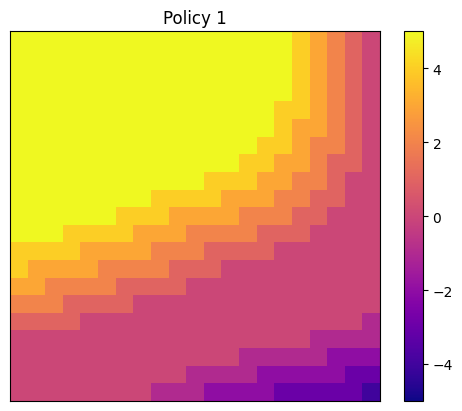

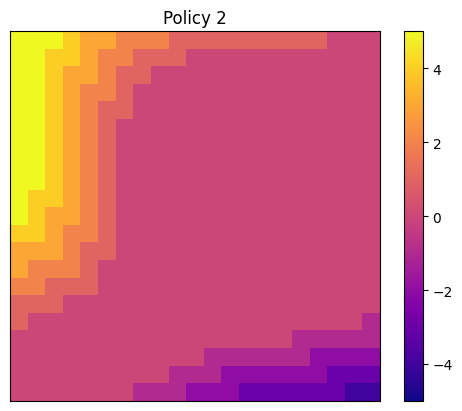

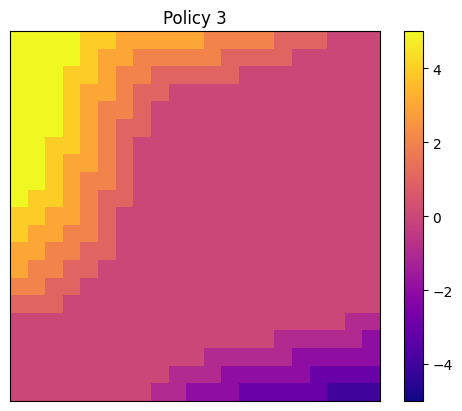

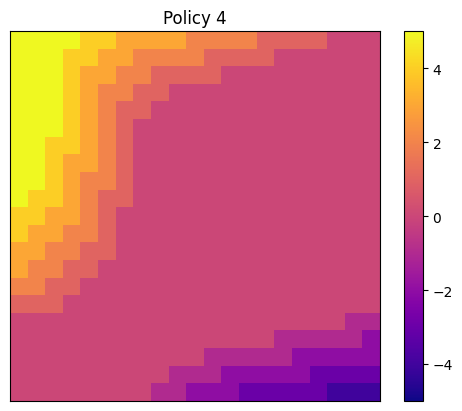

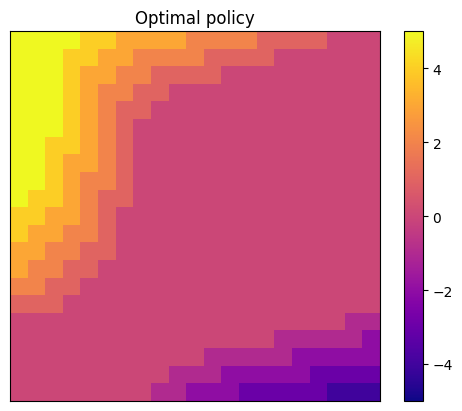

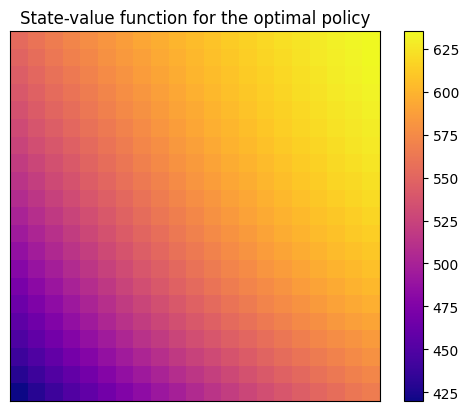

In [8]:
nvec = env.observation_space.nvec
num_states = nvec.prod()
transition_prob = env.unwrapped.prob.transpose(0, 1, 3, 4, 2)
rewards = env.unwrapped.rewards.transpose(0, 1, 3, 4, 2)
C_ = env.unwrapped.prob.reshape(*env.unwrapped.prob.shape[:-2], -1)
b_ = (transition_prob * rewards).sum(axis=(2, 3))

# Initialization
gamma = 0.9
policy = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32)
policy[:, :, 0] = 1.0
V = np.zeros(num_states)
theta = 0.001
iteration = 0

while True:
    # Policy Evaluation
    pol = np.expand_dims(policy, (2, 4))
    C = (transition_prob @ pol).reshape(num_states, num_states)
    b = ((transition_prob * rewards).sum(axis=(2, 3), keepdims=True) @ pol).reshape(num_states)
    while True:
        v = V.copy()
        V = b + gamma * C @ V
        delta = max(abs(V - v))
        if delta < theta:
            break

    # Policy Improvement
    plot_policy(policy, title=f"Policy {iteration}")
    old_deterministic = get_deterministic(policy)
    A = b_ + gamma * C_ @ V
    argmax = A == np.max(A, axis=2, keepdims=True)
    policy = argmax / np.sum(argmax, axis=2, keepdims=True)
    deterministic = get_deterministic(policy)
    if not np.any(deterministic - old_deterministic):
        break

    iteration += 1

V = V.reshape(nvec)
plot_policy(policy, title="Optimal policy")
plot_value(V, title="State-value function for the optimal policy")

#### Exercise 4.4
The policy iteration algorithm on page 80 has a subtle bug in that it may never terminate if the policy continually switches between two or more policies that are equally good. This is okay for pedagogy, but not for actual use. Modify the pseudocode so that convergence is guaranteed.

- ***If there is more than one argmax, choose deterministically the action (e.g. the first one)***
- ***Another option is to check if the old-action is an element of the set of all argmax***

#### Exercise 4.5
How would policy iteration be defined for action values? Give a complete algorithm for computing $q_*$, analogous to that on page 80 for computing $v_*$. Please pay special attention to this exercise, because the ideas involved will be used throughout the rest of the book.

***Policy Iteration (using iterative policy evaluation for action values) for estimating $\pi \approx \pi_*$****
1. Initialization\
$Q(s, a) \in \mathbb{R}$ and $\pi(s) \in \mathcal{A}(s)$ arbitrarily for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$; $\pi(\text{terminal}) \doteq \text{null}$; $Q(\text{terminal}, \text{null}) \doteq 0$
2. Policy Evaluation\
Loop:\
&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow 0$\
&nbsp;&nbsp;&nbsp;&nbsp;Loop for each $s \in \mathcal{S}$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Loop for each $a \in \mathcal{A}(s)$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$q \leftarrow Q(s, a)$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(s, a) \leftarrow \sum_{s', r} p(s', r| s, a)[r + \gamma Q(s', \pi(s'))]$\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow \max(\Delta, |q - Q(s, a)|)$\
until $\Delta < \theta$ (a small positive number determining the accuracy of estimation)
3. Policy Improvement\
$\textit{policy-stable} \leftarrow true$\
For each $s \in \mathcal{S}$:\
&nbsp;&nbsp;&nbsp;&nbsp;$\textit{old-action} \leftarrow \pi(s)$\
&nbsp;&nbsp;&nbsp;&nbsp;$\pi(s) \leftarrow \argmax_a Q(s, a)$\
&nbsp;&nbsp;&nbsp;&nbsp;If $\textit{old-action} \neq \pi(s)$, then $\textit{policy-stable} \leftarrow false$\
If $\textit{policy-stable}$, then stop and return $Q \approx q_*$ and $\pi \approx \pi_*$; else go to 2

#### Exercise 4.6
Suppose you are restricted to considering only policies that are $\epsilon$-soft, meaning that the probability of selecting each action in each state, $s$, is at least $\epsilon/|\mathcal{A}(s)|$. Describe qualitatively the changes that would be required in each of the steps 3, 2, and 1, in that order, of the policy iteration algorithm for $v_*$ on page 80.

1. Initialize $\pi(a | s) = 1 / |\mathcal{A}(s)|$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$
2. $V(s) = \sum_a \pi(a | s) * \sum_{s', r} p(s', r| s, a) [r + \gamma  V(s')]$
3. $\pi(a | s) = \left\{\begin{array}{ll}
      (1 - \epsilon) / |\boldsymbol{\alpha}| & \text{if } a \in \boldsymbol{\alpha} & \boldsymbol{\alpha} = \argmax_a \sum_{s',r} p(s', r | s, a) [r + \gamma v(s')] \\
      \epsilon/|\mathcal{A}(s) - \boldsymbol{\alpha}| & \text{otherwise}
      \end{array} \right.$

#### Exercise 4.7 (programming)
Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs $2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

In [9]:
seed = 42
env = gym.make("CarRental-v0", modified=True)
policy = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32)
policy[:, :, 0] = 1.0

In [10]:
state, _ = env.reset(seed=seed)
np.random.seed(seed)
print("Initial state:", state)

Initial state: [16  9]


In [11]:
action = np.random.choice(env.action_space.n, p=policy[tuple(state)].flatten())
action -= env.action_space.n * (action // (-env.action_space.start + 1))
state, reward, _, _, info = env.step(action)
print("Action:", action)
print("Reward:", reward)
print("Rentals:", info["rentals"])
print("Returns:", info["returns"])
print("State:", state)

Action: 0
Reward: 86.0
Rentals: [4 5]
Returns: [4 1]
State: [16  5]


Policy Iteration (using iterative policy evaluation) for estimating $\pi \approx \pi_*$

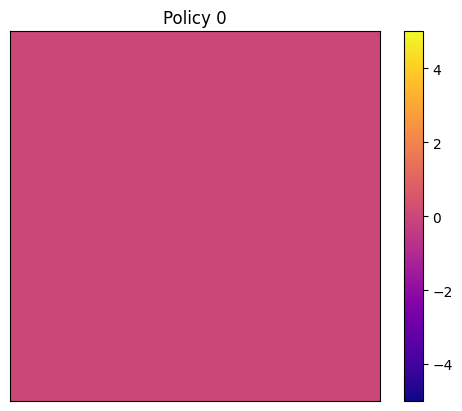

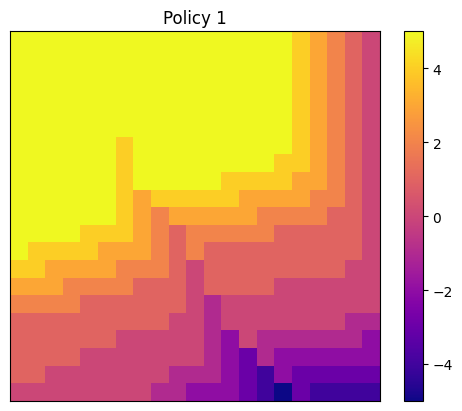

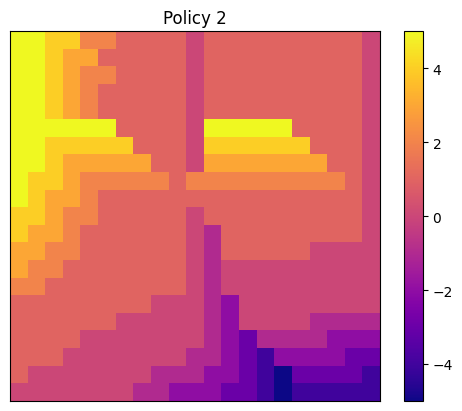

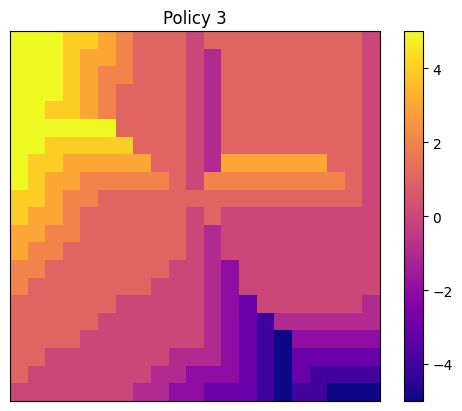

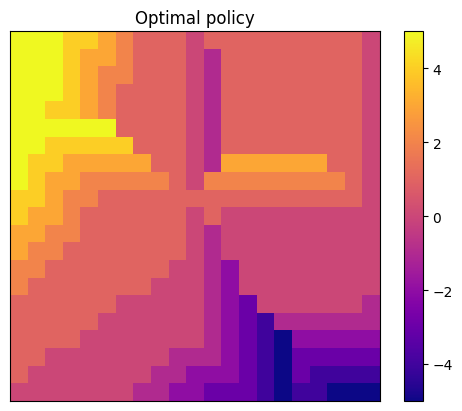

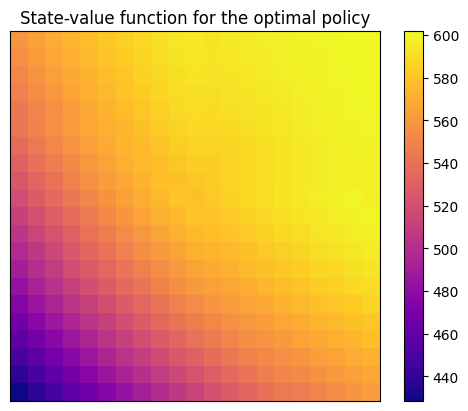

In [12]:
nvec = env.observation_space.nvec
num_states = nvec.prod()
transition_prob = env.unwrapped.prob.transpose(0, 1, 3, 4, 2)
rewards = env.unwrapped.rewards.transpose(0, 1, 3, 4, 2)
C_ = env.unwrapped.prob.reshape(*env.unwrapped.prob.shape[:-2], -1)
b_ = (transition_prob * rewards).sum(axis=(2, 3))

# Initialization
gamma = 0.9
policy = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32)
policy[:, :, 0] = 1.0
V = np.zeros(num_states)
theta = 0.001
iteration = 0

while True:
    # Policy Evaluation
    pol = np.expand_dims(policy, (2, 4))
    C = (transition_prob @ pol).reshape(num_states, num_states)
    b = ((transition_prob * rewards).sum(axis=(2, 3), keepdims=True) @ pol).reshape(num_states)
    while True:
        v = V.copy()
        V = b + gamma * C @ V
        delta = max(abs(V - v))
        if delta < theta:
            break

    # Policy Improvement
    plot_policy(policy, title=f"Policy {iteration}")
    old_deterministic = get_deterministic(policy)
    A = b_ + gamma * C_ @ V
    argmax = A == np.max(A, axis=2, keepdims=True)
    policy = argmax / np.sum(argmax, axis=2, keepdims=True)
    deterministic = get_deterministic(policy)
    if not np.any(deterministic - old_deterministic):
        break

    iteration += 1

V = V.reshape(nvec)
plot_policy(policy, title="Optimal policy")
plot_value(V, title="State-value function for the optimal policy")

#### Example 4.3: Gambler's Problem

In [13]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import gambler

seed = 42
env = gym.make("Gambler-v0", prob_heads=0.4)
policy = np.zeros((env.observation_space.n, env.action_space.n), dtype=np.float32)
policy[:, 0] = 1.0

In [14]:
state, _ = env.reset(seed=seed)
np.random.seed(seed)
print("Initial state:", state)

Initial state: 9


In [15]:
action = np.random.choice(env.action_space.n, p=policy[state].flatten())
state, reward, terminated, _, info = env.step(action)
print("Action:", action)
print("Reward:", reward)
print("Terminated:", terminated)
print("State:", state)

Action: 0
Reward: 0.0
Terminated: False
State: 9


#### Figure 4.3

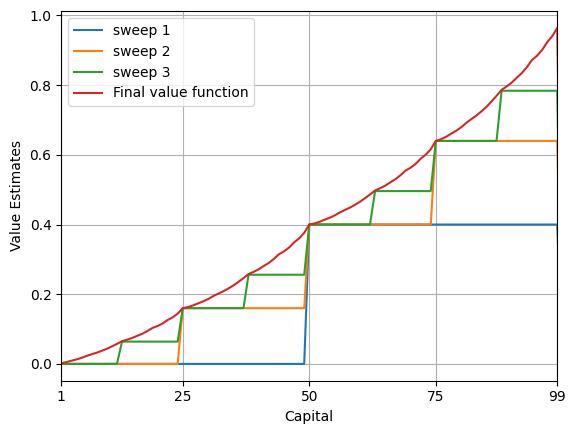

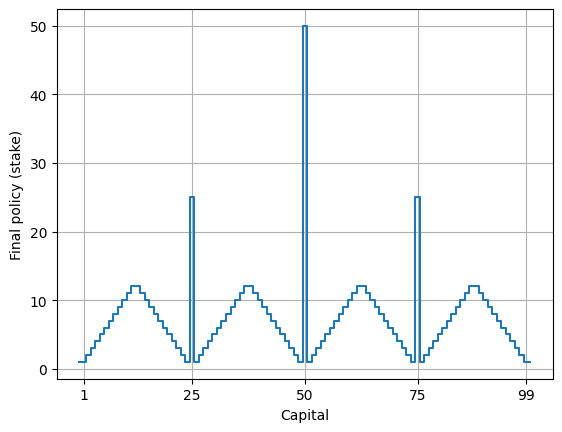

In [16]:
transition_prob = env.unwrapped.prob
rewards = env.unwrapped.rewards
C = transition_prob
b = (transition_prob * rewards).sum(axis=2)

# Initialization
gamma = 1.0
V = np.zeros(env.observation_space.n)
theta = 0.001
iteration = 0

# Value Iteration
while True:
    v = V.copy()
    V = np.max(b + gamma * C @ V, axis=1)
    delta = max(abs(V - v))
    iteration += 1
    if iteration in [1, 2, 3]:
        plt.plot(V, label=f"sweep {iteration}")
    if delta < theta:
        break
plt.plot(V, label=f"Final value function")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.xlim([1, 99])
plt.ylabel("Value Estimates")
plt.legend()
plt.grid(True)
plt.show()

# Optimal Policy
A = np.round(b + gamma * C @ V, decimals=6)
argmax = A == np.max(A, axis=1, keepdims=True)
policy = (argmax / np.sum(argmax, axis=1, keepdims=True))
deterministic = np.argmax(policy[:, 1:], axis=1) + 1
plt.step(np.arange(env.observation_space.n), deterministic, where="mid")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.ylabel("Final policy (stake)")
plt.grid(True)
plt.show()

#### Exercise 4.8
Why does the optimal policy for the gambler’s problem have such a curious form? In particular, for capital of 50 it bets it all on one flip, but for capital of 51 it does not. Why is this a good policy?

- ***When the probability of the coin coming up heads is less that 50%, the optimal policy is to minimize the number of flips as we cannot win in the limit.***
- ***For capital of 50, it has the same probability of winning as the probability of one single coin coming up heads.***
- ***For capital outside 50, the policy get us back to 50 if we lose, and up to 50 if we win.***

#### Exercise 4.9 (programming)
Implement value iteration for the gambler’s problem and solve it for $p_h = 0.25$ and $p_h = 0.55$. In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of $0$ and $100$, giving them values of $0$ and $1$ respectively. Show your results graphically, as in Figure 4.3. Are your results stable as $\theta \rightarrow 0$?

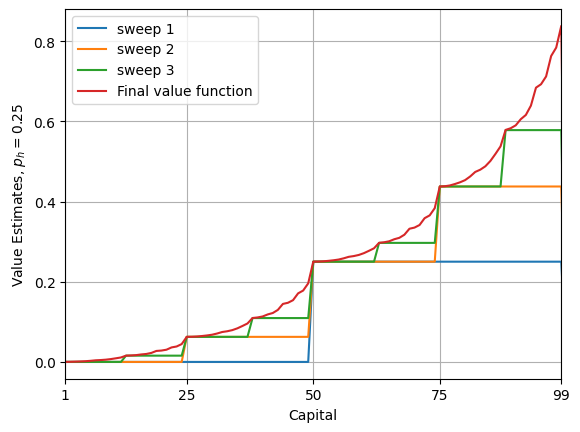

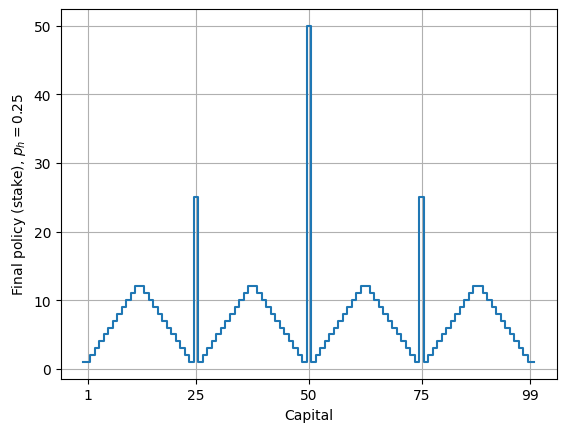

In [17]:
env = gym.make("Gambler-v0", prob_heads=0.25)

transition_prob = env.unwrapped.prob
rewards = env.unwrapped.rewards
C = transition_prob
b = (transition_prob * rewards).sum(axis=2)

# Initialization
gamma = 1.0
V = np.zeros(env.observation_space.n)
theta = 0.0001
iteration = 0

# Value Iteration
while True:
    v = V.copy()
    V = np.max(b + gamma * C @ V, axis=1)
    delta = max(abs(V - v))
    iteration += 1
    if iteration in [1, 2, 3]:
        plt.plot(V, label=f"sweep {iteration}")
    if delta < theta:
        break
plt.plot(V, label=f"Final value function")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.xlim([1, 99])
plt.ylabel(f"Value Estimates, $p_h = {env.unwrapped.prob_heads}$")
plt.legend()
plt.grid(True)
plt.show()

# Optimal Policy
A = np.round(b + gamma * C @ V, decimals=6)
argmax = A == np.max(A, axis=1, keepdims=True)
policy = (argmax / np.sum(argmax, axis=1, keepdims=True))
deterministic = np.argmax(policy[:, 1:], axis=1) + 1
plt.step(np.arange(env.observation_space.n), deterministic, where="mid")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.ylabel(f"Final policy (stake), $p_h = {env.unwrapped.prob_heads}$")
plt.grid(True)
plt.show()

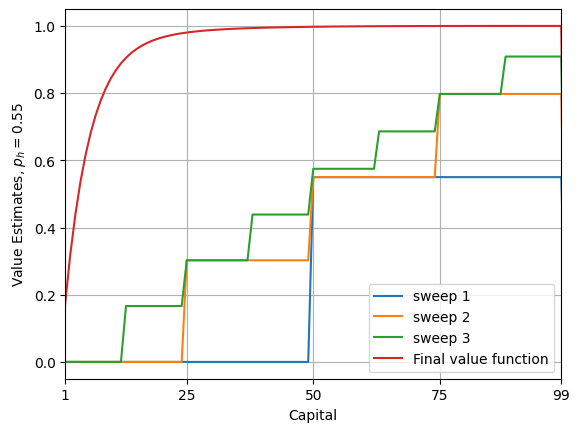

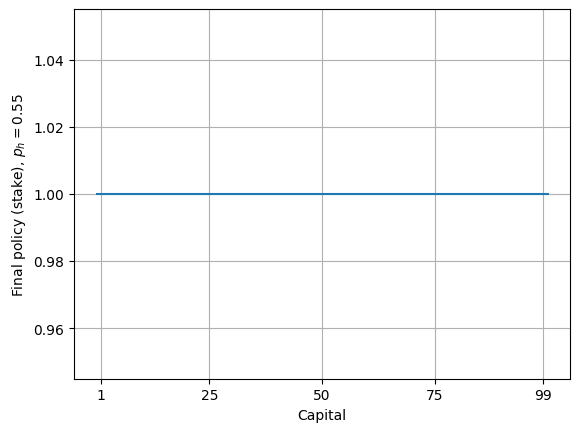

In [18]:
env = gym.make("Gambler-v0", prob_heads=0.55)

transition_prob = env.unwrapped.prob
rewards = env.unwrapped.rewards
C = transition_prob
b = (transition_prob * rewards).sum(axis=2)

# Initialization
gamma = 1.0
V = np.zeros(env.observation_space.n)
theta = 0.0001
iteration = 0

# Value Iteration
while True:
    v = V.copy()
    V = np.max(b + gamma * C @ V, axis=1)
    delta = max(abs(V - v))
    iteration += 1
    if iteration in [1, 2, 3]:
        plt.plot(V, label=f"sweep {iteration}")
    if delta < theta:
        break
plt.plot(V, label=f"Final value function")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.xlim([1, 99])
plt.ylabel(f"Value Estimates, $p_h = {env.unwrapped.prob_heads}$")
plt.legend()
plt.grid(True)
plt.show()

# Optimal Policy
A = np.round(b + gamma * C @ V, decimals=6)
argmax = A == np.max(A, axis=1, keepdims=True)
policy = (argmax / np.sum(argmax, axis=1, keepdims=True))
deterministic = np.argmax(policy[:, 1:], axis=1) + 1
plt.step(np.arange(env.observation_space.n), deterministic, where="mid")
plt.xlabel("Capital")
plt.xticks([1, 25, 50, 75, 99])
plt.ylabel(f"Final policy (stake), $p_h = {env.unwrapped.prob_heads}$")
plt.grid(True)
plt.show()

#### Exercise 4.10
What is the analog of the value iteration update (4.10) for action values, $q_{k+1}(s, a)$?

- $q_{k+1}(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} q_k(S_{t+1}, a') | S_t = s, A_t = a]$
- $q_{k+1}(s, a) = \sum_{s', r} p(s', r| s, a)[r + \gamma \max_{a'} q_k(s', a')]$